# Adding More Features

### Import Libraries

In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os

from sklearn.preprocessing import MinMaxScaler
from pykalman import KalmanFilter
from statsmodels.tsa.arima_model import ARIMA

In [2]:
raw_path = "../data/raw/"
inter_path = "../data/interim/"
final_path = "../data/processed/"

### Import Imputed Correlated Assets

In [3]:
df = pd.read_csv('../data/interim/correlated_assets_interpolated_linear.csv', sep=',').set_index('Date')
df

Change       Gain       Loss        GOOGL         Open  \
Date                                                                    
2004-08-19  -0.170170   0.000000   0.170170    50.220219    50.050049   
2004-08-20  -3.653652   0.000000   3.653652    54.209209    50.555557   
2004-08-23   0.675678   0.675678   0.000000    54.754753    55.430431   
2004-08-24   3.188187   3.188187   0.000000    52.487488    55.675674   
2004-08-25  -0.520523   0.000000   0.520523    53.053055    52.532532   
...               ...        ...        ...          ...          ...   
2020-04-22 -17.300049   0.000000  17.300049  1258.410034  1241.109985   
2020-04-23  -5.430054   0.000000   5.430054  1271.170044  1265.739990   
2020-04-24 -21.599976   0.000000  21.599976  1276.599976  1255.000000   
2020-04-27  21.140015  21.140015   0.000000  1270.859985  1292.000000   
2020-04-28  50.609985  50.609985   0.000000  1232.589966  1283.199951   

                   High          Low    Volume         AMZN       CL=F  ...  \
Date                                                                    ...   
2004-08-19    52.082081    48.028027  44659000    38.630001  48.700001  ...   
2004-08-20    54.594593    50.300301  22834300    39.509998  47.860001  ...   
2004-08-23    56.796795    54.579578  18256100    39.450001  46.049999  ...   
2004-08-24    55.855854    51.836838  15247300    39.049999  45.209999  ...   
2004-08-25    54.054054    51.991993   9188600    40.299999  43.470001  ...   
...                 ...          ...       ...          ...        ...  ...   
2020-04-22  1279.880005  1237.199951   2315800  2363.489990  13.780000  ...   
2020-04-23  1288.150024  1260.530029   1710100  2399.449951  16.500000  ...   
2020-04-24  1277.709961  1244.000000   1872000  2410.219971  16.940001  ...   
2020-04-27  1294.099976  1265.060059   2209300  2376.000000  12.780000  ...   
2020-04-28  1284.760010  1230.380005   4035000  2314.080078  12.340000  ...   

                  LRCX        LDOS       MCHP         MU        MSFT  \
Date                                                                   
2004-08-19   19.569586   23.966843  16.693291  11.470000   17.417645   
2004-08-20   19.829914   23.966843  16.960281  11.960000   17.469027   
2004-08-23   20.036385   23.966843  16.960281  12.160000   17.546322   
2004-08-24   19.282326   23.966843  16.656885  11.900000   17.546322   
2004-08-25   19.758101   23.966843  16.317072  12.030000   17.746004   
...                ...         ...        ...        ...         ...   
2020-04-22  268.971832   96.899918  78.200363  43.910000  172.170059   
2020-04-23  261.232666   98.140831  77.972786  43.770000  170.086380   
2020-04-24  263.914673  101.208344  81.149078  44.160000  173.192032   
2020-04-27  261.678009  102.052170  83.820724  45.279999  172.695923   
2020-04-28  259.144470  101.575661  86.433014  45.310001  168.488922   

                  SNE         MSI  SEKJPY=X        HYG        JNK  
Date                                                               
2004-08-19  29.097370   44.306625   14.4020  42.671959  54.886005  
2004-08-20  29.783739   45.526325   14.4020  42.671959  54.886005  
2004-08-23  30.061766   45.838367   14.4020  42.671959  54.886005  
2004-08-24  30.348492   45.412884   14.4020  42.671959  54.886005  
2004-08-25  30.530949   46.519119   14.4020  42.671959  54.886005  
...               ...         ...       ...        ...        ...  
2020-04-22  62.680000  150.249466   10.6629  76.513680  93.992874  
2020-04-23  62.060001  152.251602   10.6478  76.474991  93.819244  
2020-04-24  62.959999  151.448761   10.6885  75.759186  93.201881  
2020-04-27  63.450001  153.074265   10.7017  76.068710  93.558792  
2020-04-28  62.919998  144.143936   10.7140  76.300865  93.722778  

[3950 rows x 40 columns]

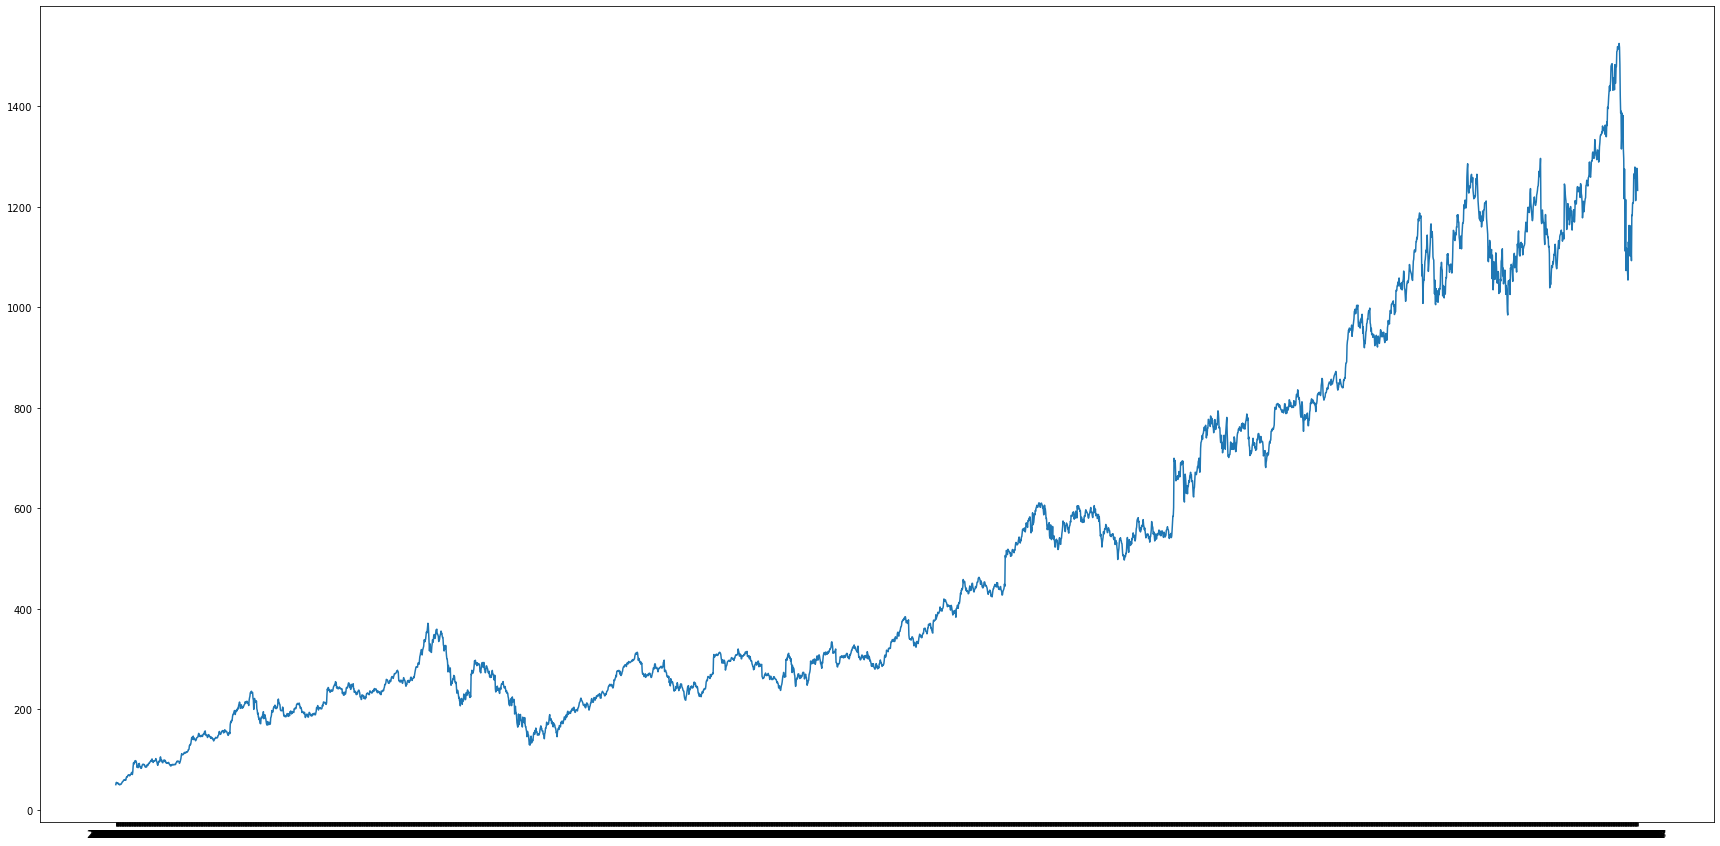

In [5]:
plt.figure(figsize=(30, 15))
plt.plot(df['GOOGL'])
plt.show()

# Making Some Technical Indicators

In [12]:
def tech_indicators(dataset, target_col, period=20, fft_comps=[40, 60, 90, 95]):
    # Create moving averages
    dataset['ma7'] = dataset[target_col].rolling(window=7).mean()
    dataset['ma21'] = dataset[target_col].rolling(window=21).mean()
    
    # MACD code
    dataset['26ema'] = dataset[target_col].ewm(span=26).mean()
    dataset['12ema'] = dataset[target_col].ewm(span=12).mean()
    dataset['macd'] = dataset['12ema'] - dataset['26ema']
    
    # Bollinger Bands code
    dataset['20sd'] = dataset[target_col].rolling(window=20).std()
    dataset['upper band'] = dataset['ma21'] + (dataset['20sd']*2)
    dataset['lower band'] = dataset['ma21'] - (dataset['20sd']*2)
    
    # Exponential moving average
    dataset['ema'] = dataset[target_col].ewm(com=0.5).mean()
    
    # Momentum
    # TODO
    #dataset['momentum'] = dataset[target_col] - 1
    
    # RSI code
    first_avg_gain = np.sum(dataset['Gain'].iloc[:period]) / period
    first_avg_loss = np.sum(dataset['Loss'].iloc[:period]) / period
    
    # Each of these are indexed at df.iloc[period]
    avg_gain = [first_avg_gain]
    avg_loss = [first_avg_loss]
    
        # We need to start indexing at period+1
    for i in range(period+1, len(df)):
        avg_gain.append(((avg_gain[-1]*(period-1)) + df['Gain'].iloc[i]) / period)
        avg_loss.append(((avg_loss[-1]*(period-1)) + df['Loss'].iloc[i]) / period)
    
    avg_gain = pd.Series(avg_gain)
    avg_loss = pd.Series(avg_loss)
    
    RS = avg_gain / avg_loss
    RSI = 100 - (100 / (1 + RS))
    RSI.index = dataset.index[period:]
    dataset['rsi'] = RSI
    
    # Stochastic Oscillator
    lows = pd.DataFrame.rolling(df[target_col], period).min()
    highs = pd.DataFrame.rolling(df[target_col], period).max()
    dataset['stoch osc'] = 100 * (df[target_col] - lows) / (highs - lows)
    
    # Chaikin Money Flow
    N = ((dataset[target_col] - dataset['Low']) - (dataset['High'] - dataset[target_col])) / (dataset["High"] - dataset["Low"])
    M_1 = N * (dataset["Volume"].rolling(window=period).sum().fillna(method='bfill'))
    M_2 = N * (dataset["Volume"].rolling(window=period-1).sum().fillna(method='bfill'))
    ADL = M_1 + M_2
    dataset['Chaikin Osc'] = ADL.ewm(span=3).mean() - ADL.ewm(span=10).mean()
    dataset["Chaikin MF"] = M_1 / (dataset["Volume"].rolling(window=period).sum().fillna(method='bfill'))
    #TODO
    
    # Fourier Transform for Trend Analysis
    """close_fft = np.fft.fft(np.asarray(dataset[target_col].tolist()))
    fft = pd.DataFrame({'fft':close_fft})
    fft['abs'] = fft['fft'].apply(lambda x: np.abs(x))
    fft['angle'] = fft['fft'].apply(lambda x: np.angle(x))

    fft_list = np.asarray(fft['fft'].tolist())
    for num_ in fft_comps:
        fft_list_m10 = np.copy(fft_list); fft_list_m10[num_:-num_]=0
        dataset[f'fft {num_}comp'] = np.real(np.fft.ifft(fft_list_m10))"""
    
    # Kalman Filter for rolling mean
    kf = KalmanFilter(transition_matrices = [1],
                  observation_matrices = [1],
                  initial_state_mean = dataset[target_col].iloc[0],
                  initial_state_covariance = 1,
                  observation_covariance=1,
                  transition_covariance=.01)

        # Use the observed values of the price to get a rolling mean
    state_means, _ = kf.filter(dataset[target_col].values)
    dataset['kf mean'] = state_means.flatten()
    
    return dataset

In [13]:
df = tech_indicators(df, 'GOOGL').fillna(method='bfill')
df.to_csv(inter_path+'linear_indicators.csv', sep=',')

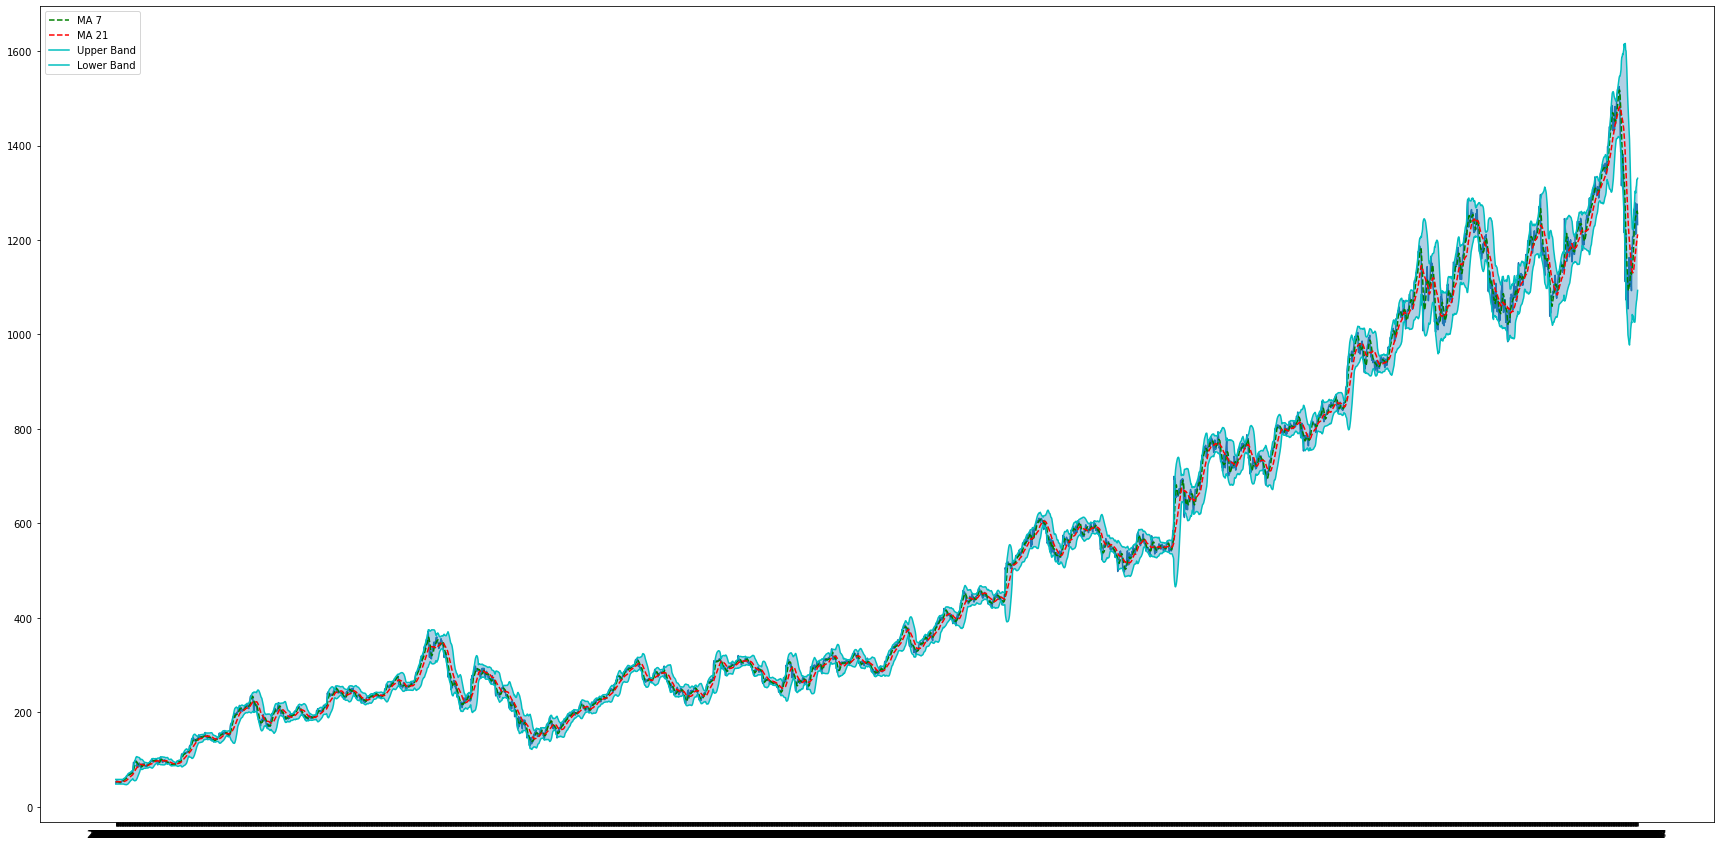

In [9]:
plt.figure(figsize=(30, 15))
plt.plot(df['GOOGL'])
plt.plot(df['ma7'],label='MA 7', color='g',linestyle='--')
plt.plot(df['ma21'],label='MA 21', color='r',linestyle='--')
plt.plot(df['upper band'],label='Upper Band', color='c')
plt.plot(df['lower band'],label='Lower Band', color='c')
plt.fill_between(df.index, df['lower band'], df['upper band'], alpha=0.35)
plt.legend(loc='upper left')
plt.show()

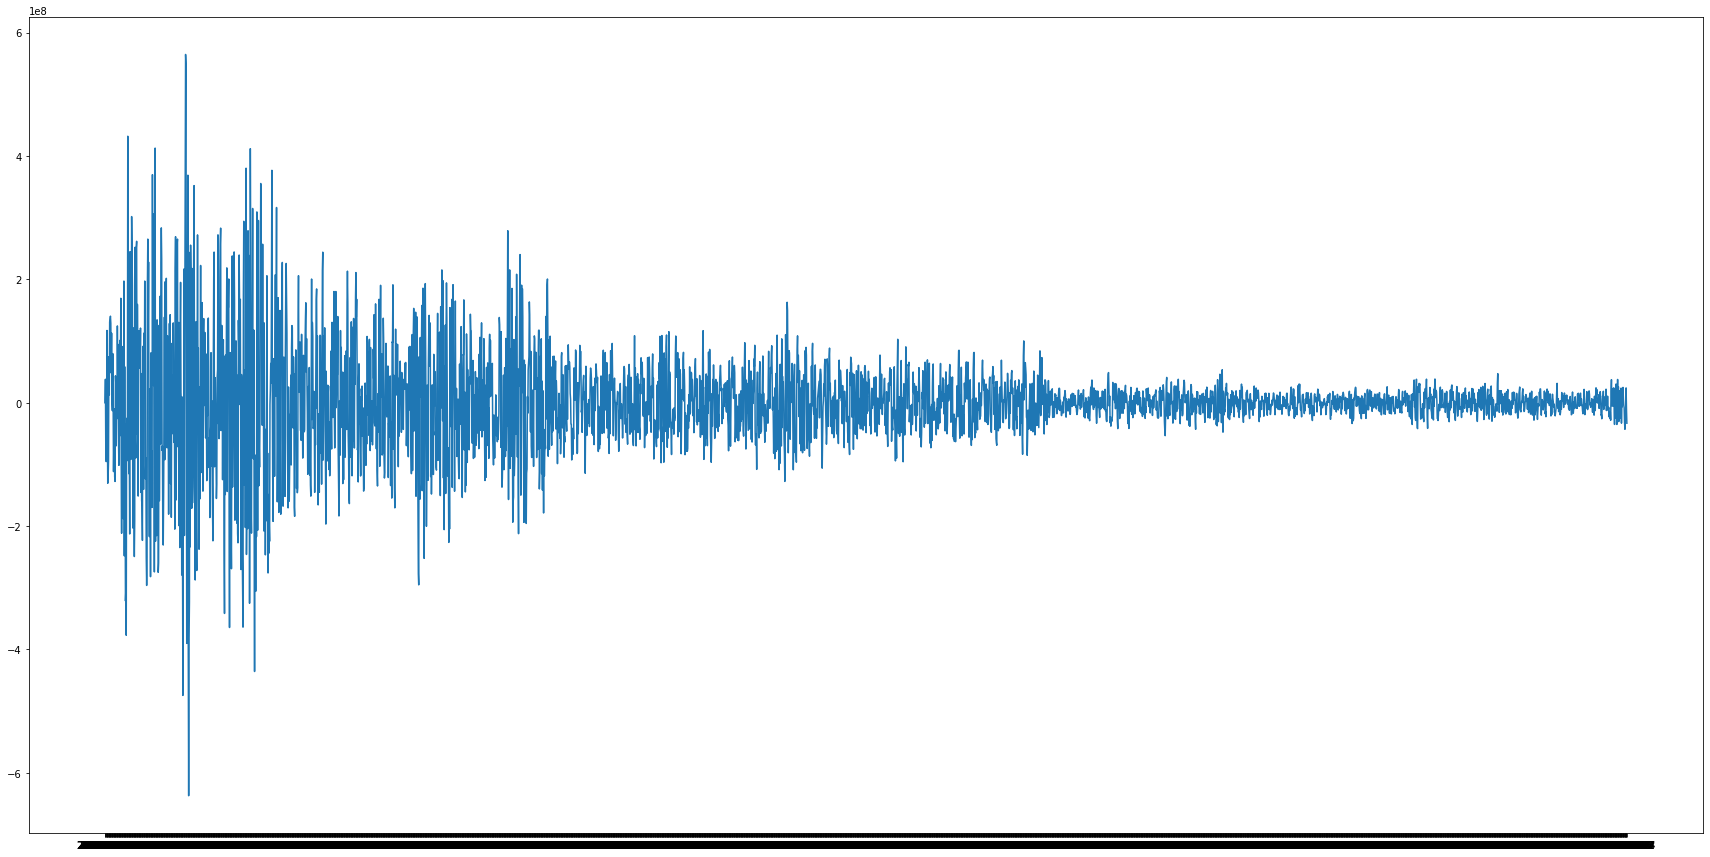

In [10]:
plt.figure(figsize=(30, 15))
plt.plot(df['Chaikin Osc'])
plt.show()

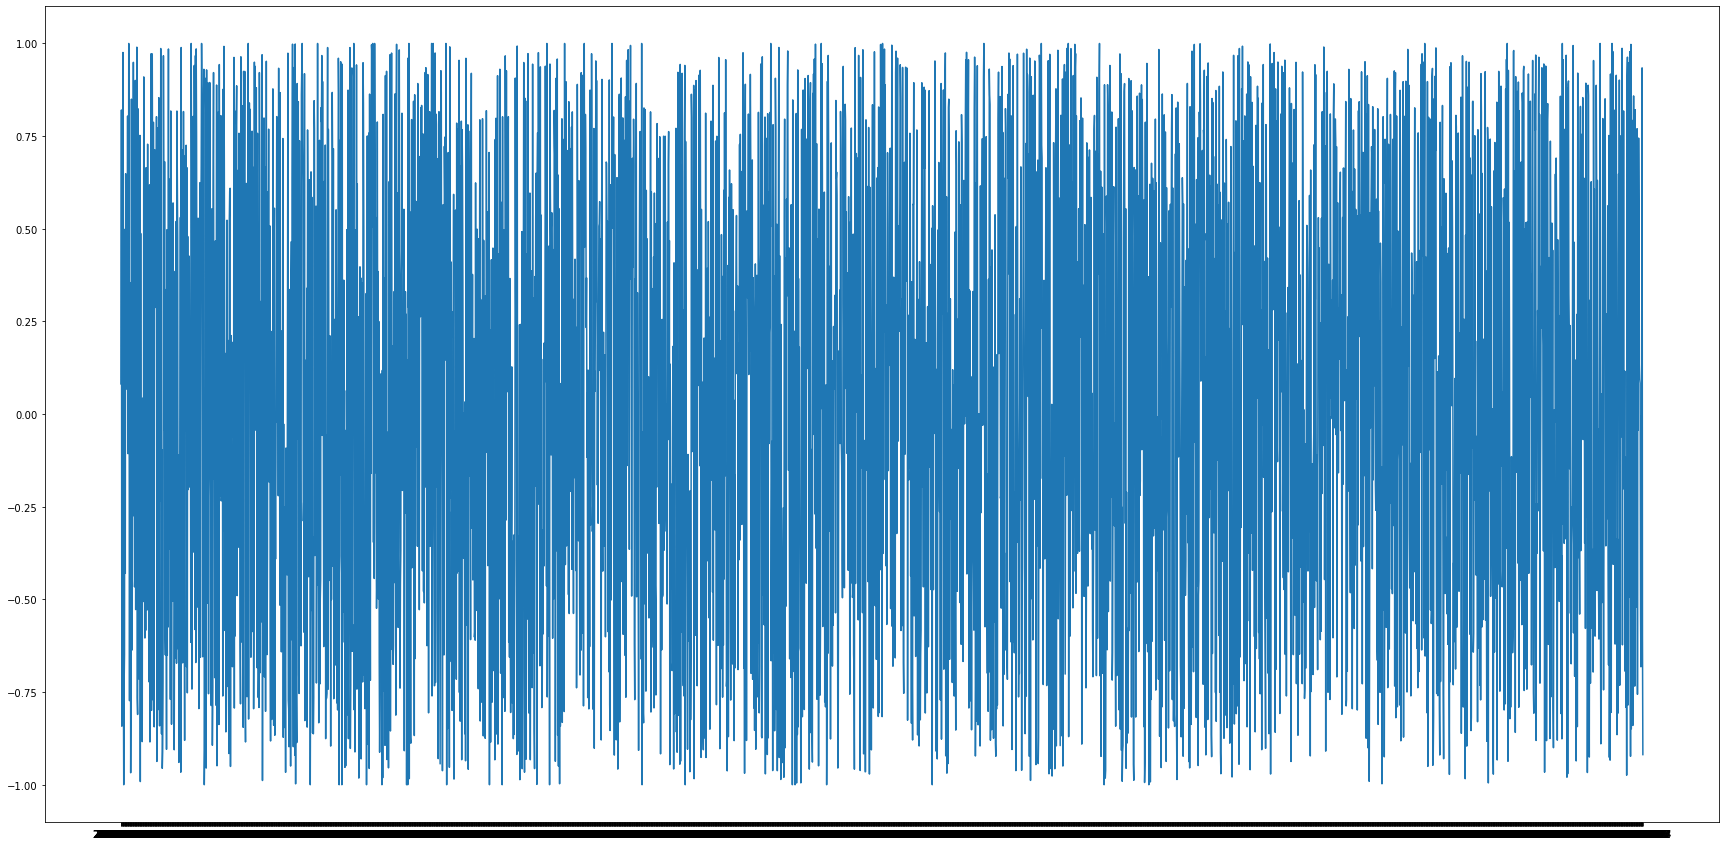

In [14]:
plt.figure(figsize=(30, 15))
plt.plot(df['Chaikin MF'])
plt.show()

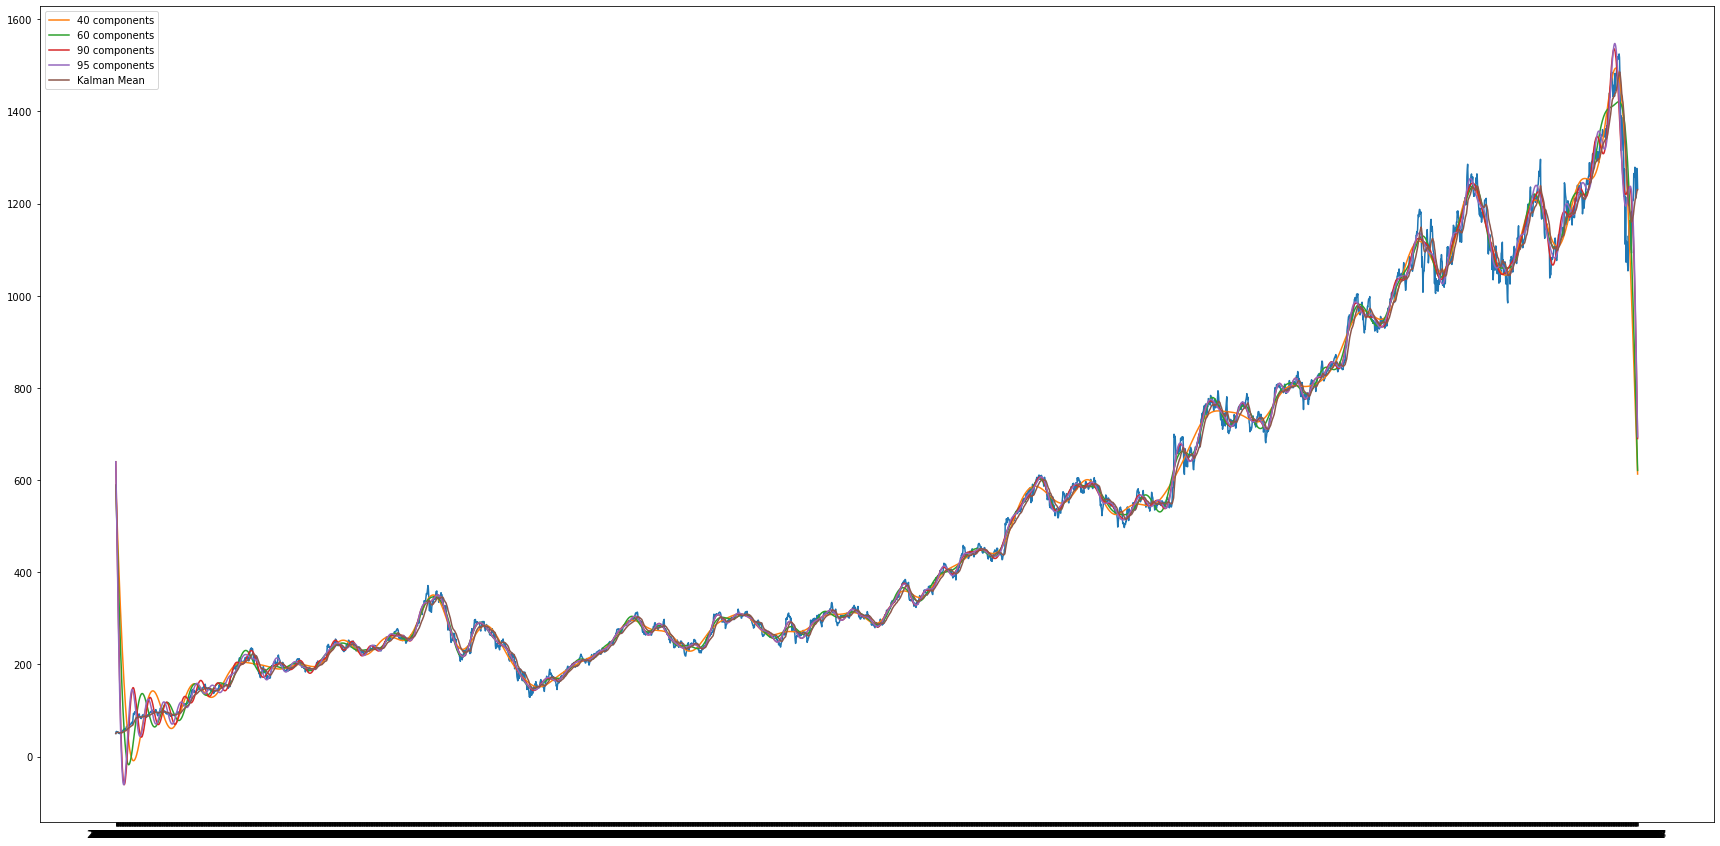

In [10]:
plt.figure(figsize=(30, 15))
plt.plot(df['GOOGL'])
plt.plot(df['fft 40comp'], label='40 components')
plt.plot(df['fft 60comp'], label='60 components')
plt.plot(df['fft 90comp'], label='90 components')
plt.plot(df['fft 95comp'], label='95 components')
plt.plot(df['kf mean'], label='Kalman Mean')
plt.legend(loc='upper left')
plt.show()

## Repeat for splined data

In [15]:
i = 1
for files in os.listdir(inter_path):
    if 'correlated_assets_interpolated_order' in files:
        print(i)
        temp_df = pd.read_csv(inter_path+files, sep=",").set_index('Date')
        temp_df = tech_indicators(temp_df, 'GOOGL').fillna(method='bfill')
        df.to_csv(inter_path+f'order{i}_indicators.csv', sep=',')
        i += 1

1
2
3
4
5


In [36]:
df

Change       Gain       Loss        GOOGL         AMZN  \
Date                                                                    
2004-08-19  -0.170170   0.000000   0.170170    50.220219    38.630001   
2004-08-20  -3.653652   0.000000   3.653652    54.209209    39.509998   
2004-08-23   0.675678   0.675678   0.000000    54.754753    39.450001   
2004-08-24   3.188187   3.188187   0.000000    52.487488    39.049999   
2004-08-25  -0.520523   0.000000   0.520523    53.053055    40.299999   
...               ...        ...        ...          ...          ...   
2020-04-22 -17.300049   0.000000  17.300049  1258.410034  2363.489990   
2020-04-23  -5.430054   0.000000   5.430054  1271.170044  2399.449951   
2020-04-24 -21.599976   0.000000  21.599976  1276.599976  2410.219971   
2020-04-27  21.140015  21.140015   0.000000  1270.859985  2376.000000   
2020-04-28  50.609985  50.609985   0.000000  1232.589966  2314.080078   

                 CL=F  EURUSD=X          FB         GC=F         GOOG  ...  \
Date                                                                   ...   
2004-08-19  48.700001  1.237195   38.230000   407.100006    49.982655  ...   
2004-08-20  47.860001  1.232195   38.230000   413.200012    53.952770  ...   
2004-08-23  46.049999  1.215200   38.230000   410.500000    54.495735  ...   
2004-08-24  45.209999  1.208196   38.230000   403.000000    52.239193  ...   
2004-08-25  43.470001  1.208605   38.230000   407.899994    52.802086  ...   
...               ...       ...         ...          ...          ...  ...   
2020-04-22  11.570000  1.085647  182.279999  1687.800049  1263.209961  ...   
2020-04-23  17.170000  1.080964  185.130005  1747.599976  1276.310059  ...   
2020-04-24  17.180000  1.077702  190.070007  1745.699951  1279.310059  ...   
2020-04-27  12.340000  1.082368  187.500000  1720.300049  1275.880005  ...   
2020-04-28  13.400000  1.082485  182.910004  1721.000000  1233.670044  ...   

             upper band   lower band          ema        rsi  stoch osc  \
Date                                                                      
2004-08-19    57.860238    48.107635    50.220219  50.261624  24.387702   
2004-08-20    57.860238    48.107635    53.211962  50.261624  24.387702   
2004-08-23    57.860238    48.107635    54.280048  50.261624  24.387702   
2004-08-24    57.860238    48.107635    53.070070  50.261624  24.387702   
2004-08-25    57.860238    48.107635    53.058680  50.261624  24.387702   
...                 ...          ...          ...        ...        ...   
2020-04-22  1310.831798  1061.102505  1248.815663  48.319872  88.947955   
2020-04-23  1315.649968  1069.728148  1263.718583  47.305793  95.797126   
2020-04-24  1327.754061  1074.288815  1272.306178  43.403624  97.511379   
2020-04-27  1328.445625  1083.877246  1271.342050  47.930627  91.559499   
2020-04-28  1330.703842  1093.269500  1245.507327  56.832725  35.924341   

            fft 40comp  fft 60comp  fft 90comp  fft 95comp      kf mean  
Date                                                                     
2004-08-19  589.091821  589.391412  639.999145  639.871552    50.220219  
2004-08-20  565.148469  557.721694  589.143458  585.303272    51.567494  
2004-08-23  541.427525  526.295354  538.130422  530.661867    52.389876  
2004-08-24  517.957189  495.190059  487.328238  476.393544    52.410508  
2004-08-25  494.765083  464.482595  437.105044  422.940917    52.526968  
...                ...         ...         ...         ...          ...  
2020-04-22  711.125163  748.660442  879.635189  896.570504  1215.178141  
2020-04-23  686.508586  716.942042  834.754248  848.730601  1220.504366  
2020-04-24  661.966964  685.079264  788.041589  798.759679  1225.840457  
2020-04-27  637.530431  653.148286  739.794715  747.025443  1230.122936  
2020-04-28  613.228864  621.226356  690.334125  693.923497  1230.357612  

[3950 rows x 49 columns]

In [45]:
df['GOOGL'] = df['GOOGL'].shift(-1)
df['Change'] = df['Change'].shift(-1)
df = df.dropna()
df

Change       Gain       Loss        GOOGL         AMZN  \
Date                                                                    
2004-08-19  -3.653652   0.000000   0.170170    54.209209    38.630001   
2004-08-20   0.675678   0.000000   3.653652    54.754753    39.509998   
2004-08-23   3.188187   0.675678   0.000000    52.487488    39.450001   
2004-08-24  -0.520523   3.188187   0.000000    53.053055    39.049999   
2004-08-25  -1.481483   0.000000   0.520523    54.009010    40.299999   
...               ...        ...        ...          ...          ...   
2020-04-21 -17.300049  30.549927   0.000000  1258.410034  2328.120117   
2020-04-22  -5.430054   0.000000  17.300049  1271.170044  2363.489990   
2020-04-23 -21.599976   0.000000   5.430054  1276.599976  2399.449951   
2020-04-24  21.140015   0.000000  21.599976  1270.859985  2410.219971   
2020-04-27  50.609985  21.140015   0.000000  1232.589966  2376.000000   

                 CL=F  EURUSD=X          FB         GC=F         GOOG  ...  \
Date                                                                   ...   
2004-08-19  48.700001  1.237195   38.230000   407.100006    49.982655  ...   
2004-08-20  47.860001  1.232195   38.230000   413.200012    53.952770  ...   
2004-08-23  46.049999  1.215200   38.230000   410.500000    54.495735  ...   
2004-08-24  45.209999  1.208196   38.230000   403.000000    52.239193  ...   
2004-08-25  43.470001  1.208605   38.230000   407.899994    52.802086  ...   
...               ...       ...         ...          ...          ...  ...   
2020-04-21   9.060000  1.086484  170.800003  1706.000000  1216.339966  ...   
2020-04-22  11.570000  1.085647  182.279999  1687.800049  1263.209961  ...   
2020-04-23  17.170000  1.080964  185.130005  1747.599976  1276.310059  ...   
2020-04-24  17.180000  1.077702  190.070007  1745.699951  1279.310059  ...   
2020-04-27  12.340000  1.082368  187.500000  1720.300049  1275.880005  ...   

             upper band   lower band          ema        rsi  stoch osc  \
Date                                                                      
2004-08-19    57.860238    48.107635    50.220219  50.261624  24.387702   
2004-08-20    57.860238    48.107635    53.211962  50.261624  24.387702   
2004-08-23    57.860238    48.107635    54.280048  50.261624  24.387702   
2004-08-24    57.860238    48.107635    53.070070  50.261624  24.387702   
2004-08-25    57.860238    48.107635    53.058680  50.261624  24.387702   
...                 ...          ...          ...        ...        ...   
2020-04-21  1299.216205  1053.262857  1229.626919  51.591745  64.122411   
2020-04-22  1310.831798  1061.102505  1248.815663  48.319872  88.947955   
2020-04-23  1315.649968  1069.728148  1263.718583  47.305793  95.797126   
2020-04-24  1327.754061  1074.288815  1272.306178  43.403624  97.511379   
2020-04-27  1328.445625  1083.877246  1271.342050  47.930627  91.559499   

            fft 40comp  fft 60comp  fft 90comp  fft 95comp      kf mean  
Date                                                                     
2004-08-19  589.091821  589.391412  639.999145  639.871552    50.220219  
2004-08-20  565.148469  557.721694  589.143458  585.303272    51.567494  
2004-08-23  541.427525  526.295354  538.130422  530.661867    52.389876  
2004-08-24  517.957189  495.190059  487.328238  476.393544    52.410508  
2004-08-25  494.765083  464.482595  437.105044  422.940917    52.526968  
...                ...         ...         ...         ...          ...  
2020-04-21  735.786377  780.159726  922.413730  941.944922  1210.633391  
2020-04-22  711.125163  748.660442  879.635189  896.570504  1215.178141  
2020-04-23  686.508586  716.942042  834.754248  848.730601  1220.504366  
2020-04-24  661.966964  685.079264  788.041589  798.759679  1225.840457  
2020-04-27  637.530431  653.148286  739.794715  747.025443  1230.122936  

[3949 rows x 49 columns]

-5.256836432047799 71.881952707954


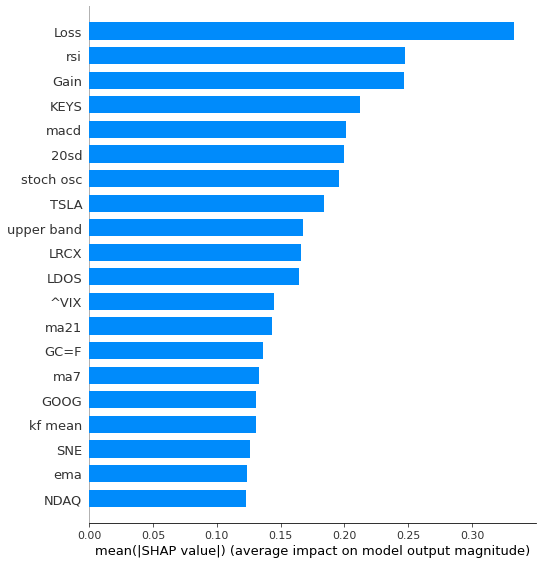

In [64]:
import xgboost as xgb
from sklearn.ensemble import ExtraTreesRegressor
import shap
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_squared_error
shap.initjs()

trainX, testX, trainY, testY = train_test_split(df.drop(['GOOGL', 'Change'], axis=1), df['Change'], test_size=0.33)

mod = ExtraTreesRegressor(n_jobs=-1)
mod.fit(trainX, trainY)

print(r2_score(mod.predict(testX), testY), mean_squared_error(mod.predict(testX), testY))

explainer = shap.TreeExplainer(mod)
shap_values = explainer.shap_values(testX)

shap.summary_plot(shap_values, testX, plot_type='bar')

In [65]:
shap.force_plot(explainer.expected_value, shap_values, testX)

## Kalman Filter

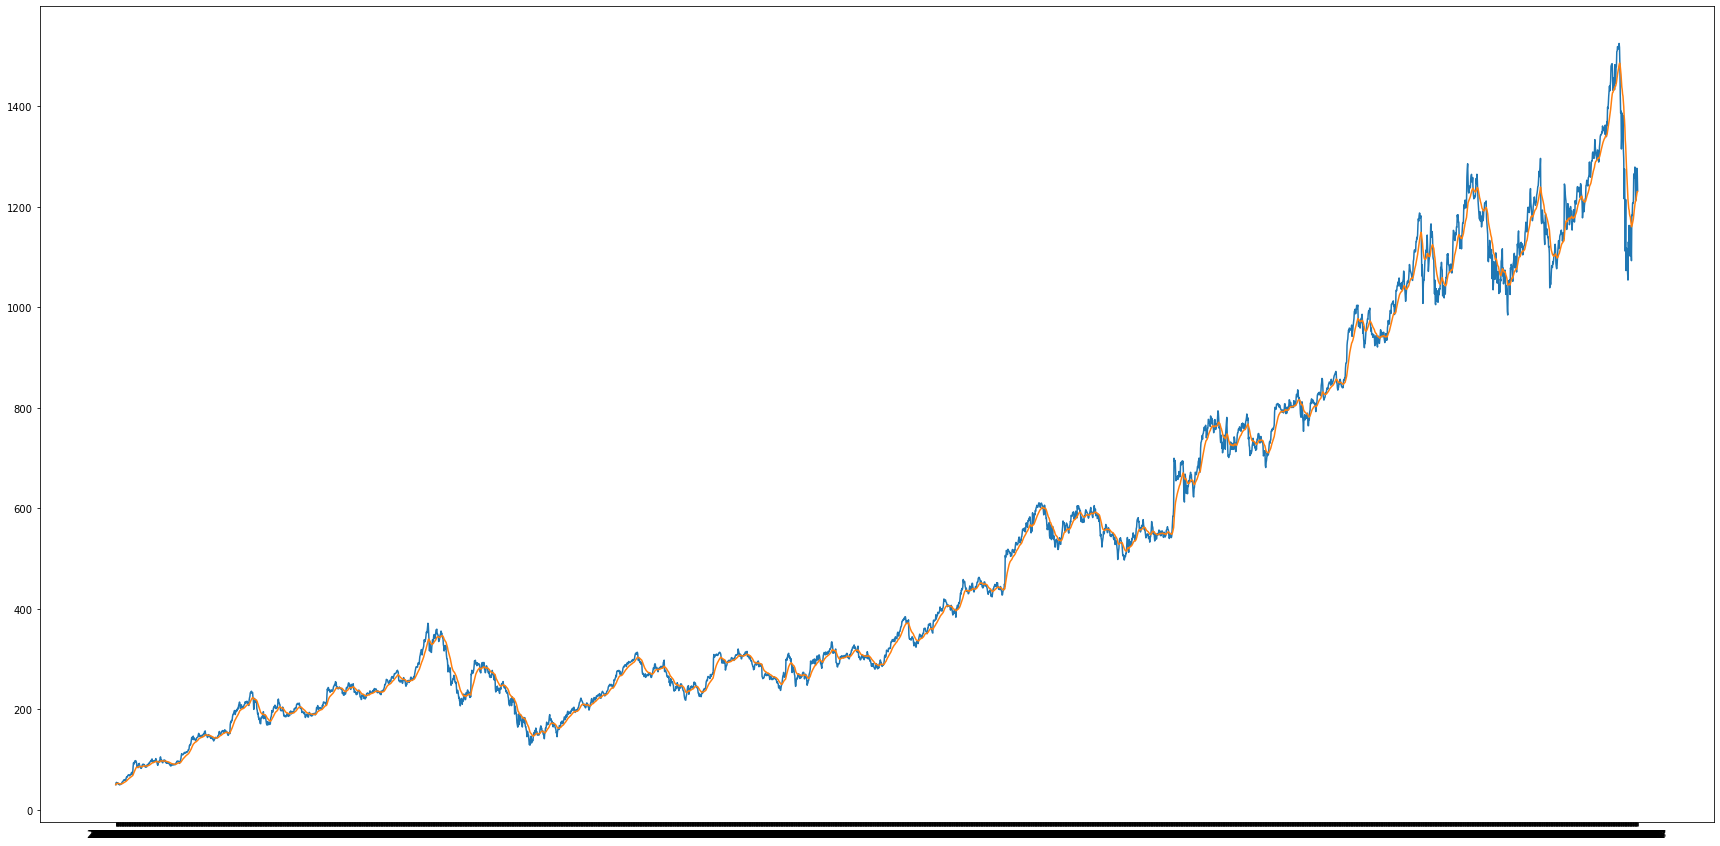

In [23]:
seq = df['GOOGL']
kf = KalmanFilter(transition_matrices = [1],
                  observation_matrices = [1],
                  initial_state_mean = seq.iloc[0],
                  initial_state_covariance = 1,
                  observation_covariance=1,
                  transition_covariance=.01)

# Use the observed values of the price to get a rolling mean
state_means, _ = kf.filter(seq.values)
state_means = pd.Series(state_means.flatten(), index=seq.index)

plt.figure(figsize=(30, 15))
plt.plot(seq, label='Original')
plt.plot(state_means, label='Kalman Filter')
plt.show()

## ARIMA as a feature

In [46]:
seq = df['GOOGL']

model = ARIMA(seq, order=(5, 1, 0))
model_fit = model.fit()
print(model_fit.summary())

C:\Users\namit\Anaconda3\envs\rl_gan\lib\site-packages\statsmodels\tsa\base\tsa_model.py:216: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
C:\Users\namit\Anaconda3\envs\rl_gan\lib\site-packages\statsmodels\tsa\base\tsa_model.py:216: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'


                             ARIMA Model Results                              
Dep. Variable:                D.GOOGL   No. Observations:                 3949
Model:                 ARIMA(5, 1, 0)   Log Likelihood              -14936.601
Method:                       css-mle   S.D. of innovations             10.627
Date:                Sun, 17 May 2020   AIC                          29887.202
Time:                        03:33:27   BIC                          29931.170
Sample:                             1   HQIC                         29902.798
                                                                              
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
const             0.3001      0.158      1.897      0.058      -0.010       0.610
ar.L1.D.GOOGL    -0.1065      0.016     -6.681      0.000      -0.138      -0.075
ar.L2.D.GOOGL     0.0204      0.016     

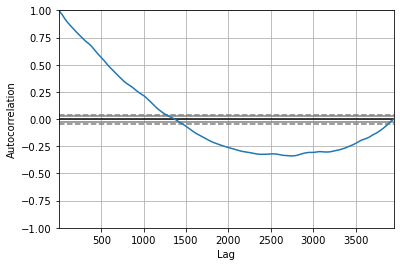

<Figure size 720x360 with 0 Axes>

In [48]:
from pandas.plotting import autocorrelation_plot

autocorrelation_plot(seq)
plt.figure(figsize=(10, 5))
plt.show() 

In [61]:
from sklearn.metrics import mean_squared_error
X = seq.values
size = 30
train, test = X[0:size], X[size:len(X)]
history = [x for x in train]
predictions = list()
for t in range(len(test)):
    model = ARIMA(history, order=(5,1,0))
    model_fit = model.fit(disp=0)
    output = model_fit.forecast()
    yhat = output[0]
    predictions.append(yhat)
    obs = test[t]
    history.append(obs)

C:\Users\namit\Anaconda3\envs\rl_gan\lib\site-packages\statsmodels\base\model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warn('Inverting hessian failed, no bse or cov_params '
C:\Users\namit\Anaconda3\envs\rl_gan\lib\site-packages\statsmodels\base\model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


In [62]:
error = mean_squared_error(test, predictions)
print('Test MSE: %.3f' % error)

Test MSE: 115.953


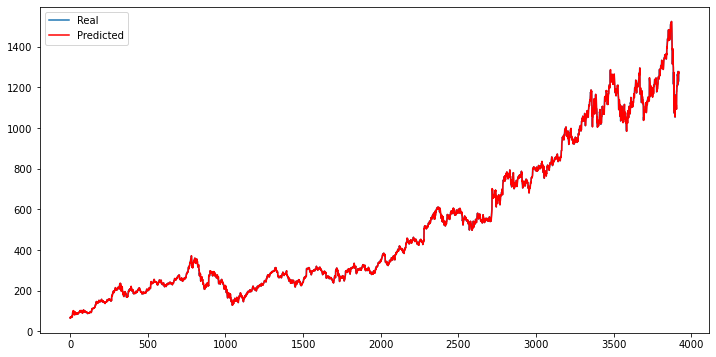

In [63]:
plt.figure(figsize=(12, 6))
plt.plot(test, label='Real')
plt.plot(predictions, color='red', label='Predicted')
plt.legend()
plt.show()

## Standardize the Data

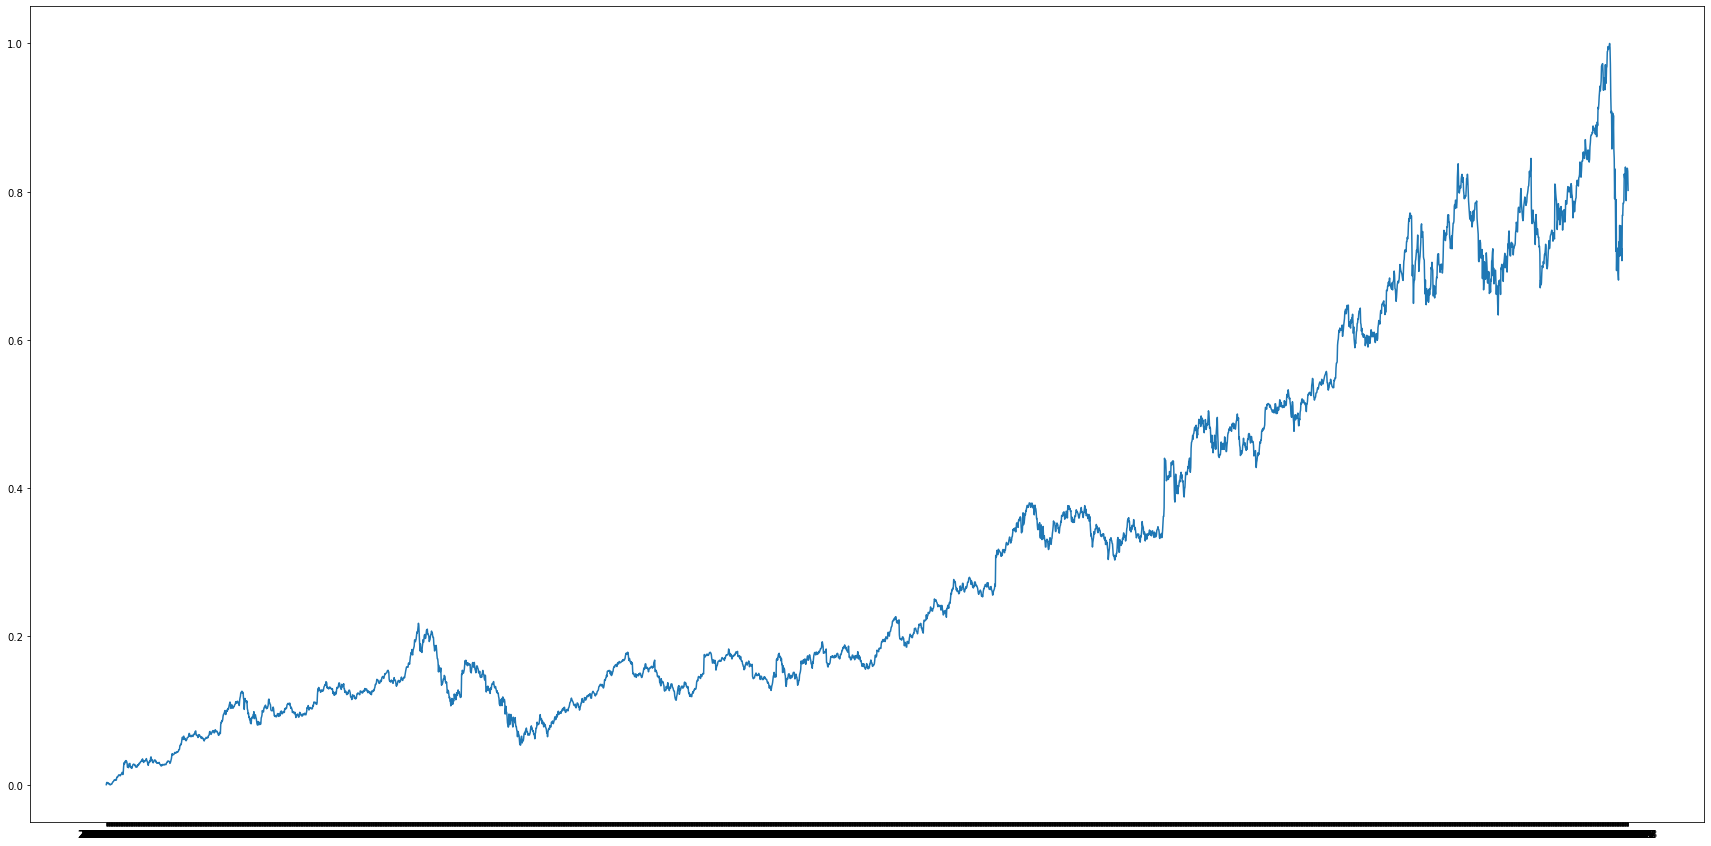

In [6]:
scaled_df = df
scaler = MinMaxScaler()
scaled_df.loc[:, :] = scaler.fit_transform(scaled_df)

plt.figure(figsize=(30, 15))
plt.plot(scaled_df['GOOGL'])
plt.show()

## De-Seasonalize the data